In [3]:
%%capture
pip install tensorflow_io tensorflow_hub pydot tensorflow==2.7.0

In [4]:
import tensorflow as tf

In [5]:
print(tf.__version__) #make sure version 2.7.0 (2.4.0 didn't work with tensorflow_io)

2.7.0


In [6]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout

# Generate listings of the files and make pairs (for training & test sets)

In [8]:
file_list1 = [] #Will hold the full filename
label_list1 = [] #Will hold the name without the .wav and version suffix

for filename in os.listdir("./test_data/"):
    if filename.endswith("wav"):
        file_list1.append(filename)
        label_list1.append(filename[:len(filename)-6]) # We take the file name and remove the last 6 characters to get the label 
                                                      # (ex: 3_ta_fatha_1.wav --> 3_ta_fatha)
    else:
        continue

file_list2 = [] #Will hold the full filename
label_list2 = [] #Will hold the name without the .wav and version suffix

for filename in os.listdir("./test_data/"):
    if filename.endswith("2.wav"):
        file_list2.append(filename)
        label_list2.append(filename[:len(filename)-6]) # We take the file name and remove the last 6 characters to get the label 
                                                      # (ex: 3_ta_fatha_1.wav --> 3_ta_fatha)
    else:
        continue

In [10]:
### This function makes pairs between wav files and labels them as the same or different

def make_pairs_full(sounds):
    # initialize two empty lists to hold the (sound, sound) pairs and
    # labels to indicate if a pair is positive or negative
    pairSounds = []
    pairLabels = []
    
    for currentSound in sounds:
        for otherSound in sounds:
            current_sound_class = currentSound[:len(currentSound)-6] #Remove the number and '.wav' part of each currentSound file name
            other_sound_class = otherSound[:len(otherSound)-6] #Remove the number and '.wav' part of each otherSound file name
                  
            if(([currentSound, otherSound] in pairSounds) or ([otherSound, currentSound] in pairSounds)):
                # If the combo is in the list, ignore (don't want duplicates)
                continue
            else:
                pairSounds.append([currentSound, otherSound]) #Append each pair to the list
                if(current_sound_class == other_sound_class): #If the pair is of the same class (letter), append 1.0, else append 0.0
                    pairLabels.append([1.0])
                else:
                    pairLabels.append([0.0])
                
    # return a 2-tuple of our sound pairs and labels
    # MUST SET LABELS AS TYPE 'np.float32' TO GET THIS TO WORK IN TRAINING!!!
    return (np.array(pairSounds).astype(object), np.array(pairLabels).astype(np.float32))

In [24]:
from sklearn.model_selection import train_test_split

#Get all unique pairs and corresponding same-class labels
(pairTrain_full_temp, labelTrain_full_temp) = make_pairs_full(file_list1) 

#Do train test split
pairTrain_full, pairTest_full, labelTrain_full, labelTest_full = train_test_split(pairTrain_full_temp, 
                                                                                  labelTrain_full_temp, 
                                                                                  test_size=0.20, 
                                                                                  random_state=42)

In [34]:
#Verify that split worked (I'm paranoid)
print( len(pairTrain_full) )
print( len(pairTest_full) )
print( len(pairTrain_full) + len(pairTest_full) ) # ( (n*(n+1))/2 unique combos --> ((54*55)/2) )
print( len(pairTrain_full_temp) )

1188
297
1485
1485


In [26]:
### RUN THIS CODE ONCE PER DATAFRAME!!! ###
### Otherwise, full file paths will be incorrect ###

path = './test_data/'

#Enumerate over train and test set pairs and modify names to include full path to files
for i, file in enumerate(pairTrain_full):
    pairTrain_full[i] = [path+file[0], path+file[1]]
    
for i, file in enumerate(pairTest_full):
    pairTest_full[i] = [path+file[0], path+file[1]]

# Load and pre-process wav files for file name listings

In [30]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [31]:
# Returns a shortened version of the waveform vector passed in
# Looks for the index of the point with the greatest amplitude (midpoint), 
# then takes the first half and a few indices after the midpoint

def wav_file_shortener(waveform_vec, length_post_max_index):
    max_amplitude = np.argmax(waveform_vec) #Find the index with the highest amplitude
    
    starting_index = max(max_amplitude-4000, 0) #starting index is 0 if index of max amp - 4000 is negative
    middle_index = max_amplitude
    ending_index = min(max_amplitude+4000, len(waveform_vec)-1) #ending index is length if index of max amp + 4000 exceeds it

    # Shortened waveform is from starting index up to midpoint + however many additional 
    # indices the user wants to add/experiment with
    shortened_waveform = waveform_vec[starting_index:middle_index+length_post_max_index]
    
    return shortened_waveform

In [32]:
### This block takes the training and testing lists of
### wav files and converts them to vectors

pairTrain_wav_16k_vec = []

for i, file in enumerate(pairTrain_full):
    file_1_vec = load_wav_16k_mono(file[0])
    file_1_vec = wav_file_shortener(file_1_vec, 0) #Shorten waveform to get most important parts
    file_2_vec = load_wav_16k_mono(file[1])
    file_2_vec = wav_file_shortener(file_2_vec, 0) #Shorten waveform to get most important parts
    pairTrain_wav_16k_vec.append([file_1_vec, file_2_vec])

print(len(pairTrain_wav_16k_vec))
pairTrain_wav_16k_vec_np = np.array(pairTrain_wav_16k_vec, dtype=object) #Convert list of vectors to numpy array


pairTest_wav_16k_vec = []

for i, file in enumerate(pairTest_full):
    file_1_vec = load_wav_16k_mono(file[0])
    file_1_vec = wav_file_shortener(file_1_vec, 0) #Shorten waveform to get most important parts
    file_2_vec = load_wav_16k_mono(file[1])
    file_2_vec = wav_file_shortener(file_2_vec, 0) #Shorten waveform to get most important parts
    pairTest_wav_16k_vec.append([file_1_vec, file_2_vec])

print(len(pairTest_wav_16k_vec))
pairTest_wav_16k_vec_np = np.array(pairTest_wav_16k_vec, dtype=object) #Convert list of vectors to numpy array

1188
297


# Load pre-trained model (for embeddings) and begin extracting embeddings for wav files

In [36]:
# This loads a pre-trained model from TF-hub to extract embeddings
model_handle = 'https://tfhub.dev/google/nonsemantic-speech-benchmark/trill/3'
embedding_extraction = hub.load(model_handle)

# If you get the error 'OSError: SavedModel file does not exist at:', follow instructions at:
# https://stackoverflow.com/questions/63078695/savedmodel-file-does-not-exist-when-using-tensorflow-hub

In [37]:
# This block enumerates through each vector, extracts the 
# embeddings using the TRILL pre-trained model, & appends to list
# (Can take a few minutes to run)

pairTrain_embeddings = []

for i, vec in enumerate(pairTrain_wav_16k_vec_np):
    vec_1_embedding = embedding_extraction(samples=vec[0], sample_rate=16000)['embedding']
    vec_2_embedding = embedding_extraction(samples=vec[1], sample_rate=16000)['embedding']
    pairTrain_embeddings.append([vec_1_embedding, vec_2_embedding])

print(len(pairTrain_embeddings))

pairTest_embeddings = []

for i, vec in enumerate(pairTest_wav_16k_vec_np):
    vec_1_embedding = embedding_extraction(samples=vec[0], sample_rate=16000)['embedding']
    vec_2_embedding = embedding_extraction(samples=vec[1], sample_rate=16000)['embedding']
    pairTest_embeddings.append([vec_1_embedding, vec_2_embedding])

print(len(pairTest_embeddings))

1188
297


In [38]:
# Take the embedding pairs and put in separate lists (for training stage further below)

# Training data
first_embedding_list_train = [i[0] for i in pairTrain_embeddings] #Embedding of the first wav vec in each pair
second_embedding_list_train = [i[1] for i in pairTrain_embeddings] #Embedding of the second wav vec in each pair

# Test/validation set
first_embedding_list_test = [i[0] for i in pairTest_embeddings] #Embedding of the first wav vec in each pair
second_embedding_list_test = [i[0] for i in pairTest_embeddings] #Embedding of the first wav vec in each pair

# Model architecture code with helper functions

In [40]:
import tensorflow.keras.backend as K

# This function will be used in the Siamese network to measure distance between input embeddings

def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors

    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)

    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [41]:
# ### UNCOMMENT AS NEEDED (If you want to use this for loss) ###

# import tensorflow.keras.backend as K
# import tensorflow as tf

# # This function calculates contrastive loss

# def contrastive_loss(y, preds, margin=1):
#     # explicitly cast the true class label data type to the predicted
#     # class label data type (otherwise we run the risk of having two
#     # separate data types, causing TensorFlow to error out)
#     y = tf.cast(y, preds.dtype)
#     # calculate the contrastive loss between the true labels and
#     # the predicted labels
#     squaredPreds = K.square(preds)
#     squaredMargin = K.square(K.maximum(margin - preds, 0))
#     loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
#     # return the computed contrastive loss to the calling function
#     return loss

In [42]:
# Will use these to take the TRILL embeddings directly as inputs rather than include TRILL directly in the architecture
featsA = tf.keras.layers.Input(shape=(512), dtype=tf.float32, name='input_embeddingA')
featsB = tf.keras.layers.Input(shape=(512), dtype=tf.float32, name='input_embeddingB')

# Construct the siamese network
distance = tf.keras.layers.Lambda(euclidean_distance, name='euclidean_distance')([featsA, featsB]) #Distance between input embeddings
middle_layer1 = Dense(10, activation='relu', name='intermediary1')(distance) #Intermediary layer 1
middle_layer2 = Dense(10, activation='relu', name='intermediary2')(middle_layer1) #Intermediary layer 2
dropout = Dropout(0.25, seed=0, name='dropout')(middle_layer2) #Dropout layer (for regularization)
outputs = Dense(1, activation="sigmoid", name='distance')(dropout) #Output layer
model = Model(inputs=[featsA, featsB], outputs=outputs) #Bring it all together

In [43]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.compile(loss=contrastive_loss, optimizer="adam", metrics=["accuracy"])

[INFO] compiling model...


In [44]:
#Display model structure
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_embeddingA (InputLayer)  [(None, 512)]        0           []                               
                                                                                                  
 input_embeddingB (InputLayer)  [(None, 512)]        0           []                               
                                                                                                  
 euclidean_distance (Lambda)    (None, 1)            0           ['input_embeddingA[0][0]',       
                                                                  'input_embeddingB[0][0]']       
                                                                                                  
 intermediary1 (Dense)          (None, 10)           20          ['euclidean_distance[0][0]'] 

# Model Training

In [45]:
# Must restack to transform to acceptable format for training
first_dim_restack_train = len(tf.stack(first_embedding_list_train))
first_dim_restack_test = len(tf.stack(first_embedding_list_test))

In [47]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior() # Needed to get reshape to work below

In [48]:
#### RUN THE 'model ='' and 'model.compile' CELLS FIRST TO AVOID INCREMENTAL FITTING (WHICH CAN LEAD TO OVERFITTING) ######

# train the model
print("[INFO] training model...")
history = model.fit(
    {'input_embeddingA': tf.stack(first_embedding_list_train).reshape(first_dim_restack_train,512), #Need to reshape to go from 3d to 2d ((12,1,1024)-->(12,1024))
     'input_embeddingB': tf.stack(second_embedding_list_train).reshape(first_dim_restack_train,512)}, 
    {'distance': labelTrain_full},
    validation_data=([tf.stack(first_embedding_list_test).reshape(first_dim_restack_test,512), 
                      tf.stack(second_embedding_list_test).reshape(first_dim_restack_test,512)], labelTest_full),
    batch_size = 32,
    epochs=10)

[INFO] training model...
Epoch 1/10
38/38 [==============================] - 1s 5ms/step - loss: 0.6274 - accuracy: 0.8056 - val_loss: 0.6293 - val_accuracy: 0.9428
Epoch 2/10
38/38 [==============================] - 0s 2ms/step - loss: 0.5042 - accuracy: 0.9411 - val_loss: 0.5589 - val_accuracy: 0.9428
Epoch 3/10
38/38 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.9444 - val_loss: 0.4913 - val_accuracy: 0.9428
Epoch 4/10
38/38 [==============================] - 0s 2ms/step - loss: 0.3057 - accuracy: 0.9436 - val_loss: 0.4305 - val_accuracy: 0.9428
Epoch 5/10
38/38 [==============================] - 0s 2ms/step - loss: 0.2468 - accuracy: 0.9461 - val_loss: 0.3837 - val_accuracy: 0.9428
Epoch 6/10
38/38 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.9461 - val_loss: 0.3515 - val_accuracy: 0.9428
Epoch 7/10
38/38 [==============================] - 0s 2ms/step - loss: 0.1824 - accuracy: 0.9461 - val_loss: 0.3303 - val_accuracy: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


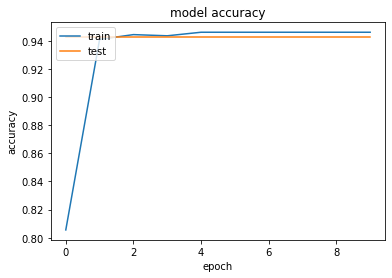

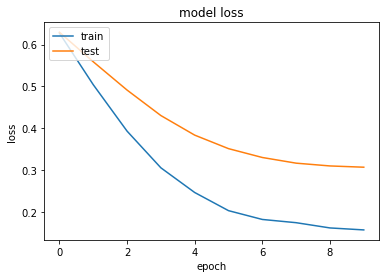

In [49]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Scoring/Demoing

In [52]:
import os

scoring_file_list_v1 = [] #Get filenames and paths and store in list for v1 wavs
scoring_file_list_v2 = [] #Get filenames and paths and store in list for v2 wavs

for filename in os.listdir("./test_data/"):
    if filename.endswith("1.wav"):
        scoring_file_list_v1.append(filename)
    elif filename.endswith("2.wav"):
        scoring_file_list_v2.append(filename)
    else:
        continue

In [65]:
# This function will take a given phoneme, cross calculate 
# model-predicted similarity with all the other phonemes,
# and return the most similar one
def get_phoneme_letter_prediction(phoneme_file):
    # Dictionary with similarity scores between all v2 phonemes & provided phoneme
    similarity_score_dictionary = {}
    
    file = phoneme_file # Provided phoneme
    parent_folder = './test_data/'
    filepath = parent_folder + file
    
    scoring_waveform_anchor = load_wav_16k_mono(filepath) #Get waveform for training data anchor
    scoring_waveform_anchor = wav_file_shortener(scoring_waveform_anchor, 0) #Shorten waveform to get most important parts
    scoring_waveform_anchor_embedding = embedding_extraction(samples=scoring_waveform_anchor, sample_rate=16000)['embedding'] #Get embedding for provided phoneme
    
    # Iterate over all phonemes in v2 list
    for file2 in scoring_file_list_v2:
        filepath2 = parent_folder + file2
        
        scoring_waveform_anchor2 = load_wav_16k_mono(filepath2) #Get waveform for training data anchor
        scoring_waveform_anchor2 = wav_file_shortener(scoring_waveform_anchor2, 0) #Shorten waveform to get most important parts
        scoring_waveform_anchor_embedding2 = embedding_extraction(samples=scoring_waveform_anchor2, sample_rate=16000)['embedding'] #Get embedding for v2 phoneme
        
        #Get same class likelihood value from model
        similarity_score = model.predict([scoring_waveform_anchor_embedding, scoring_waveform_anchor_embedding2])[0][0]
        
        #remove unwanted text to get class name
        anchor_phoneme_temp = filepath2.replace('./test_data/','')
        anchor_phoneme = anchor_phoneme_temp.replace('.wav','')
        
        similarity_score_dictionary[anchor_phoneme] = similarity_score
        
    return max(similarity_score_dictionary, key=similarity_score_dictionary.get) #Return phoneme with highest same-class similarity from model
        

In [69]:
from IPython.display import Image

# This function returns an image of the letter corresponding to the phoneme output 
# from the get_phoneme_letter_prediction function
def get_letter_of_phoneme(phoneme_name):
    temp_name = phoneme_name # temp variable for phoneme name
    
    path = './letter_images/'
    result = temp_name[:len(temp_name)-8] # removes suffix we don't want 
    suffix = '.gif'
    
    full_path = path + result + suffix
    
    return Image(filename=full_path) 

In [173]:
# This function returns the audio of a given waveform file name
def get_waveform_audio(phoneme_name):
    parent_folder = './test_data/'
    filepath = parent_folder + phoneme_name

    waveform2 = load_wav_16k_mono(filepath)

    return display.Audio(waveform2, rate=16000)

In [211]:
phoneme_name = '20_fa_fatha_1.wav'
get_waveform_audio(phoneme_name)

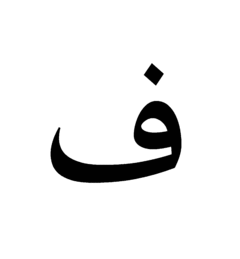

In [212]:
get_letter_of_phoneme( get_phoneme_letter_prediction(phoneme_name) )

In [213]:
phoneme_name = '23_lam_fatha_1.wav'
get_waveform_audio(phoneme_name)

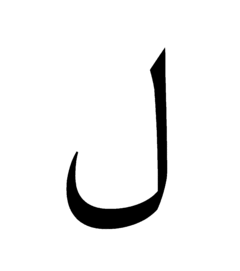

In [214]:
get_letter_of_phoneme( get_phoneme_letter_prediction(phoneme_name) )

In [215]:
phoneme_name = '12_seen_fatha_1.wav'
get_waveform_audio(phoneme_name)

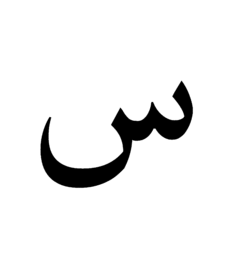

In [216]:
get_letter_of_phoneme( get_phoneme_letter_prediction(phoneme_name) )

In [217]:
phoneme_name = '16_6a_fatha_2.wav'
get_waveform_audio(phoneme_name)

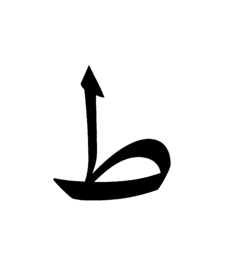

In [218]:
get_letter_of_phoneme( get_phoneme_letter_prediction(phoneme_name) )

In [219]:
phoneme_name = '28_ya_fatha_1.wav'
get_waveform_audio(phoneme_name)

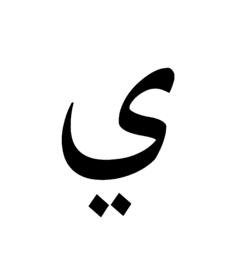

In [220]:
get_letter_of_phoneme( get_phoneme_letter_prediction(phoneme_name) )

In [221]:
phoneme_name = '25_noon_fatha_1.wav'
get_waveform_audio(phoneme_name)

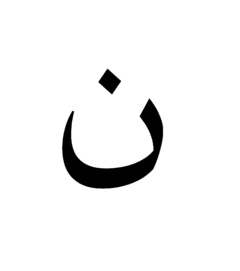

In [222]:
get_letter_of_phoneme( get_phoneme_letter_prediction(phoneme_name) )